### 가장 가까운 초등학교 정보 컬럼 추가하기.

- X, Y 좌표로 left 머지할것.

In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

In [11]:
dt_newXY_for_Train = pd.read_csv('data/newXY_for_train.csv')
dt_newXY_for_Test = pd.read_csv('data/newXY_for_test.csv')

dt_newXY = pd.concat([dt_newXY_for_Train, dt_newXY_for_Test])
dt_newXY.reset_index(inplace=True, drop=True)
dt = dt_newXY.drop_duplicates()
dt.reset_index(inplace=True, drop=True)
dt

,좌표X_2,좌표Y_2
0,127.056859,37.476276
1,127.056019,37.483975
2,127.076624,37.496296
3,127.061582,37.478484
4,127.068516,37.487597
...,...,...
8950,126.960768,37.500333
8951,126.935943,37.544878
8952,127.063437,37.548714
8953,126.996582,37.564606


In [10]:
dt_elemSchool = pd.read_excel('data/서울시_초등학교.xlsx')
dt_elemSchool

,학교명,위도,경도
0,서울대림초등학교,37.500615,126.924883
1,서울강일초등학교,37.565256,127.177286
2,서울양남초등학교,37.531123,127.089234
3,서울충무초등학교,37.561949,127.001235
4,서울잠동초등학교,37.518338,127.099931
...,...,...,...
600,청원초등학교,37.665252,127.062533
601,서울신계초등학교,37.629792,127.052769
602,서울도봉초등학교,37.679962,127.038289
603,서울백산초등학교,37.446740,126.905146


In [12]:
import numpy as np
from sklearn.neighbors import BallTree
from haversine import haversine, Unit

apartment_coords = dt[['좌표Y_2', '좌표X_2']].values
elemSchool_coords = dt_elemSchool[['위도', '경도']].values

tree = BallTree(elemSchool_coords, metric='haversine')
_, indices = tree.query(apartment_coords, k=1)  # distances 는 값이 이상하여 따로 계산하자.

distances = np.array([haversine((ac[0], ac[1]), (elemSchool_coords[i, 0], elemSchool_coords[i, 1]), unit=Unit.KILOMETERS)
                      for ac, i in zip(apartment_coords, indices)])

dt['최단거리초등학교명'] = dt_elemSchool.loc[indices.flatten(), '학교명'].values
dt['최단거리초등학교Km'] = distances

In [13]:
dt

,좌표X_2,좌표Y_2,최단거리초등학교명,최단거리초등학교Km
0,127.056859,37.476276,서울포이초등학교,0.385832
1,127.056019,37.483975,서울개일초등학교,0.291634
2,127.076624,37.496296,서울대진초등학교,0.148287
3,127.061582,37.478484,서울개현초등학교,0.256165
4,127.068516,37.487597,서울개포초등학교,0.190272
...,...,...,...,...
8950,126.960768,37.500333,서울은로초등학교,0.321256
8951,126.935943,37.544878,서울신석초등학교,0.166289
8952,127.063437,37.548714,서울성수초등학교,0.487360
8953,126.996582,37.564606,서울충무초등학교,0.505446


In [14]:
display(dt['최단거리초등학교명'].isnull().sum())
display(dt['최단거리초등학교Km'].isnull().sum())

0

0

In [15]:
dt[['좌표X_2', '좌표Y_2', '최단거리초등학교명', '최단거리초등학교Km']]

,좌표X_2,좌표Y_2,최단거리초등학교명,최단거리초등학교Km
0,127.056859,37.476276,서울포이초등학교,0.385832
1,127.056019,37.483975,서울개일초등학교,0.291634
2,127.076624,37.496296,서울대진초등학교,0.148287
3,127.061582,37.478484,서울개현초등학교,0.256165
4,127.068516,37.487597,서울개포초등학교,0.190272
...,...,...,...,...
8950,126.960768,37.500333,서울은로초등학교,0.321256
8951,126.935943,37.544878,서울신석초등학교,0.166289
8952,127.063437,37.548714,서울성수초등학교,0.487360
8953,126.996582,37.564606,서울충무초등학교,0.505446


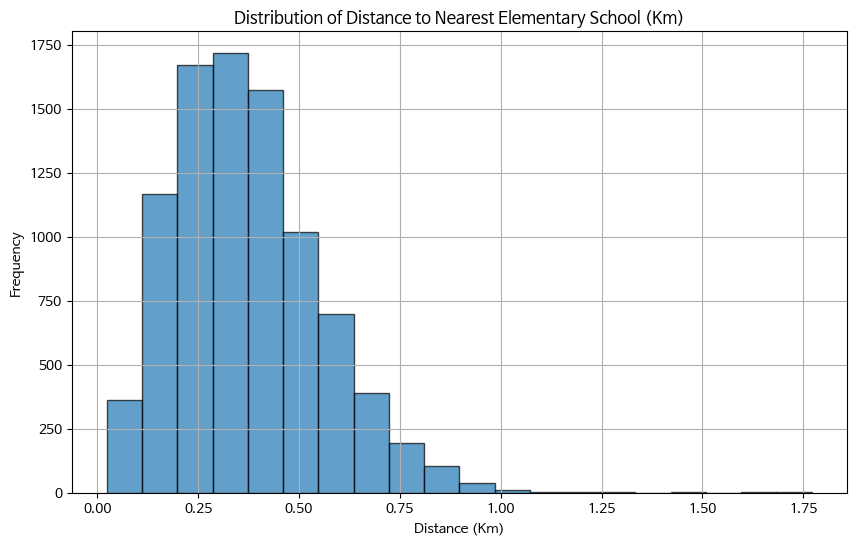

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# 히스토그램 그리기
plt.figure(figsize=(10, 6))
plt.hist(dt['최단거리초등학교Km'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of Distance to Nearest Elementary School (Km)')
plt.xlabel('Distance (Km)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [17]:
dt.to_csv('data/elemSchool_with_XY.csv', encoding='utf-8-sig', index=False)